In [2]:
import os
import re

import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from umap import UMAP
from sklearn.preprocessing import StandardScaler


In [3]:
import torch

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import violet
from violet.utils.attention import plot_image_attention, plot_multichannel_attention
from violet.utils.model import predict
from violet.utils.dataloaders import multichannel_image_dataloader, listfiles, dino_he_transform
from violet.utils.analysis import plot_image_umap, display_2d_scatter
from violet.utils.model import load_pretrained_model
from violet.utils.multichannel import create_pseudocolor_image, retile_multichannel_image

In [7]:
img_dir = '/home/estorrs/violet/data/codex/tile_test_panc_07062021_512res_no_backround/'
weights = '/home/estorrs/violet/sandbox/dino_runs/multichannel_07072021_res512_no_background/checkpoint0260.pth'

In [8]:
dataloader = multichannel_image_dataloader(img_dir, shuffle=False, pad=True)

/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [9]:
model = load_pretrained_model(weights, in_chans=len(dataloader.dataset.channels))

Take key teacher in provided checkpoint dict
Pretrained weights found at /home/estorrs/violet/sandbox/dino_runs/multichannel_07072021_res512_no_background/checkpoint0260.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [10]:
dataloader.dataset.channels

['CD107a',
 'CD11c',
 'CD20',
 'CD21',
 'CD31',
 'CD3e',
 'CD4',
 'CD44',
 'CD45',
 'CD45RO',
 'CD68',
 'CD8',
 'DAPI',
 'HLADR',
 'Ki67',
 'Mac2',
 'actin',
 'ecadherin',
 'pancytok']

In [11]:
len(dataloader.dataset.samples)

300

In [12]:
b = next(iter(dataloader))
b.shape

torch.Size([64, 19, 224, 224])

0


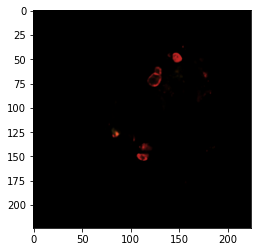

1


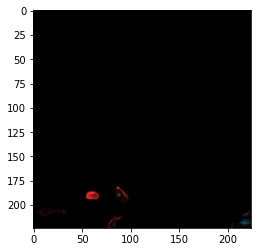

2


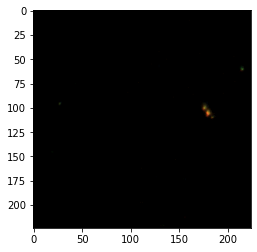

3


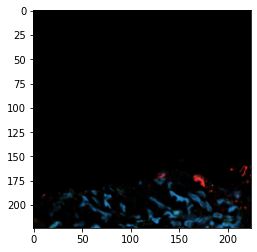

4


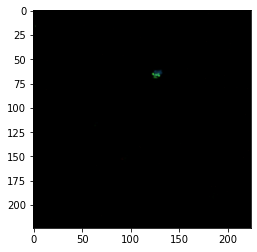

5


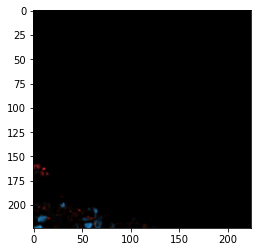

6


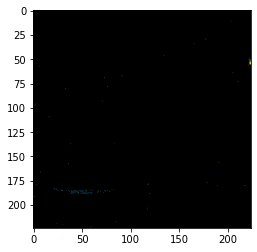

7


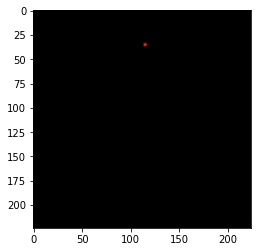

8


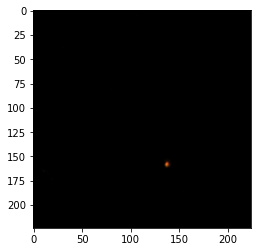

9


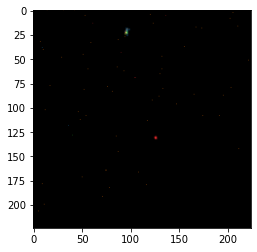

10


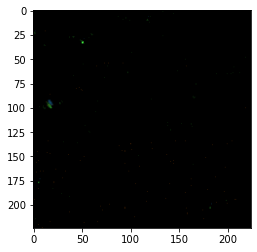

11


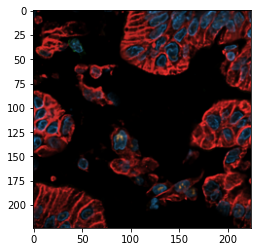

12


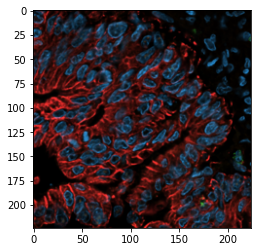

13


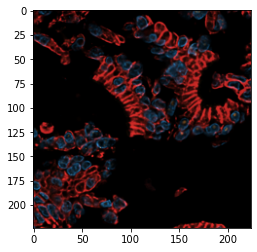

14


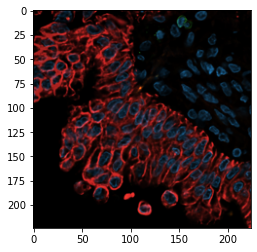

15


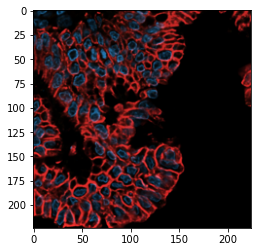

16


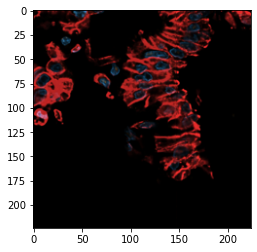

17


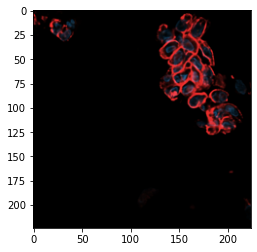

18


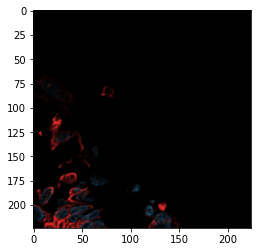

19


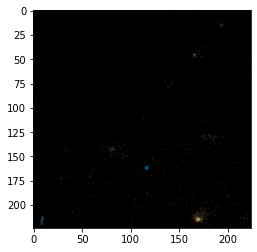

20


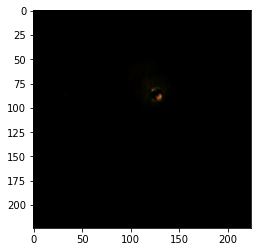

21


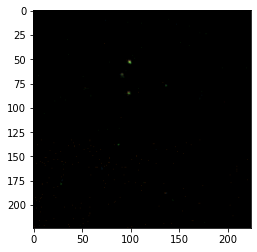

22


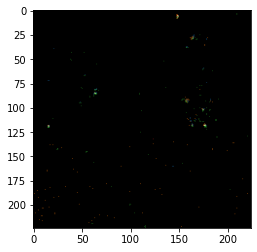

23


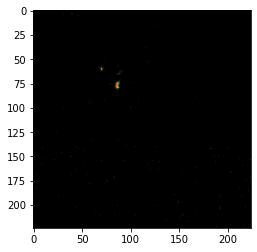

24


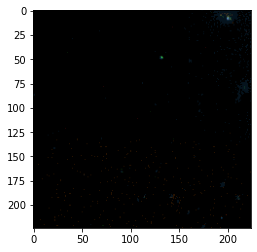

25


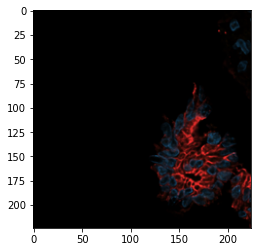

26


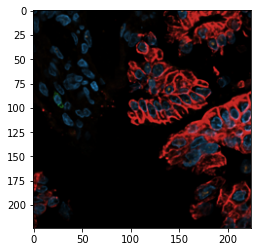

27


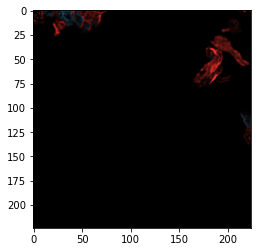

28


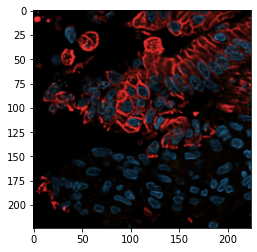

29


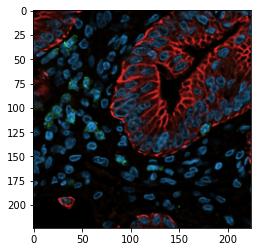

30


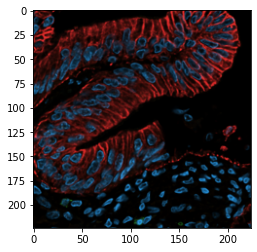

31


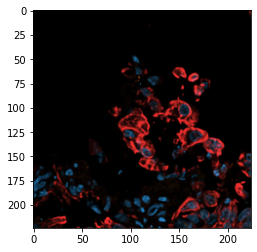

32


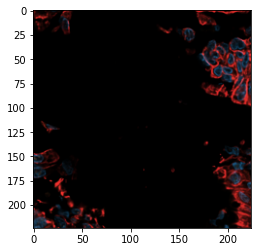

33


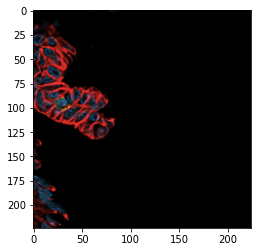

34


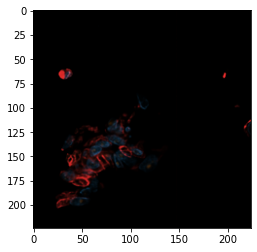

35


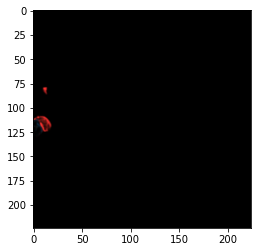

36


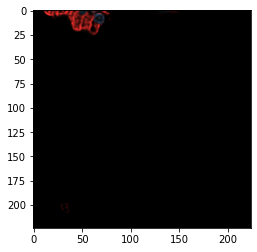

37


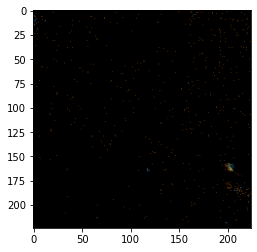

38


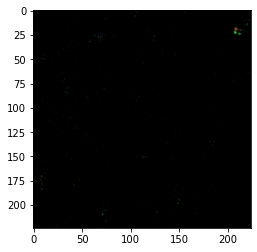

39


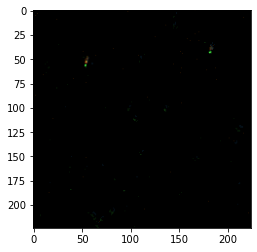

40


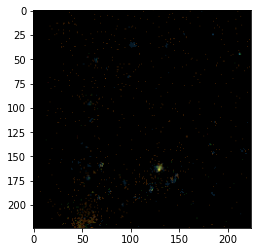

41


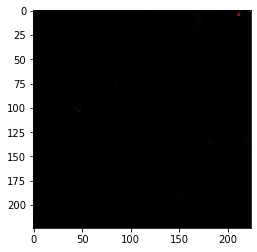

42


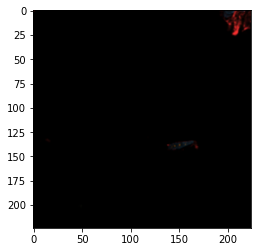

43


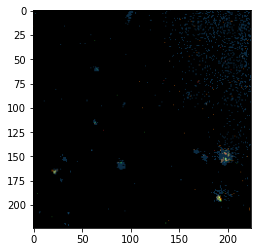

44


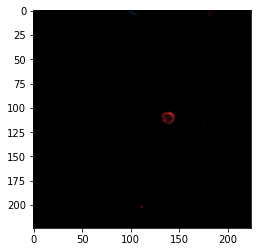

45


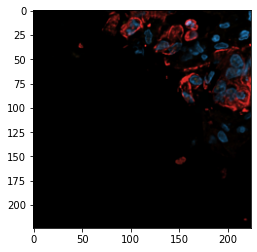

46


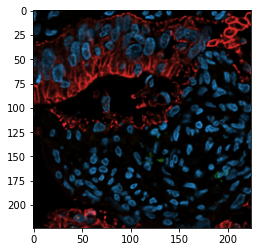

47


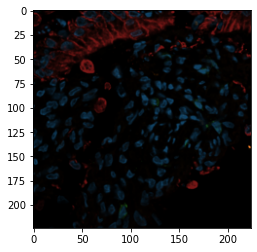

48


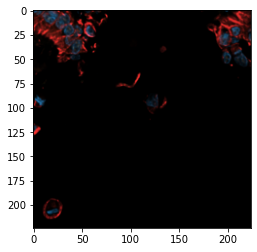

49


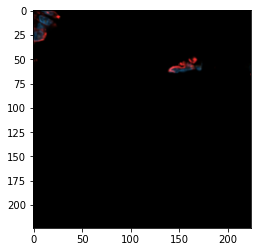

50


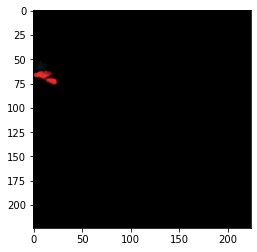

51


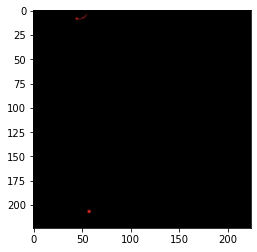

52


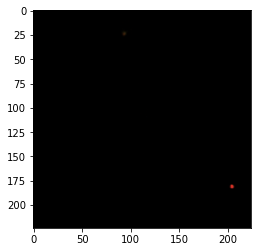

53


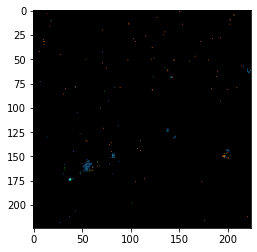

54


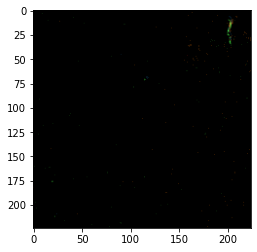

55


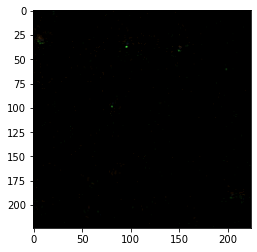

56


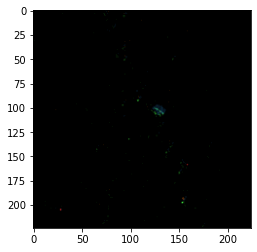

57


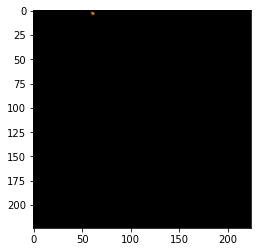

58


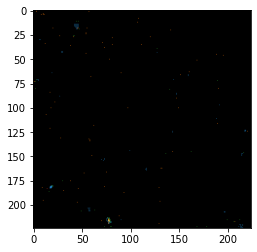

59


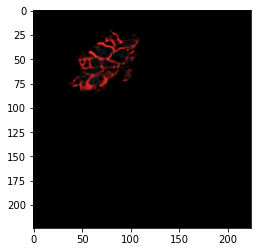

60


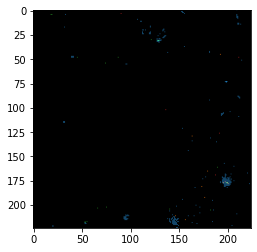

61


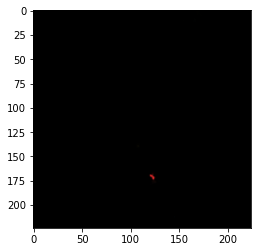

62


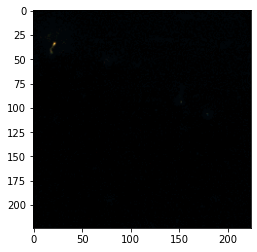

63


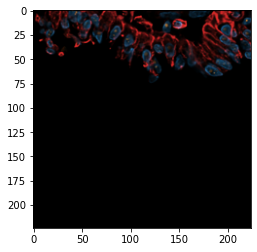

In [13]:
import matplotlib.pyplot as plt
pseudos = []
for i, x in enumerate(b):
    print(i)
    pseudo = create_pseudocolor_image(x, dataloader.dataset, ['DAPI', 'CD20', 'CD8', 'pancytok'])
    plt.imshow(pseudo)
    plt.show()
    pseudos.append(pseudo)

In [14]:
test, pseudo = b[46], pseudos[46]

(<Figure size 720x288 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'head 0'}, ylabel='overlay'>,
         <AxesSubplot:title={'center':'head 1'}>,
         <AxesSubplot:title={'center':'head 2'}>,
         <AxesSubplot:title={'center':'head 3'}>,
         <AxesSubplot:title={'center':'head 4'}>,
         <AxesSubplot:title={'center':'head 5'}>],
        [<AxesSubplot:ylabel='image'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='attention'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

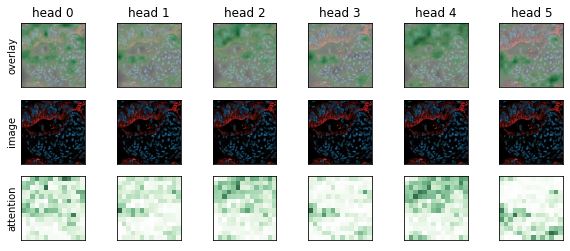

In [15]:
plot_multichannel_attention(test, pseudo, model)

In [16]:
embs = predict(dataloader, model)

In [17]:
embs.shape

(300, 384)

In [18]:
x = UMAP(n_components=2).fit_transform(embs)

In [19]:
adata = anndata.AnnData(X=embs)
adata.obs.index = [s for s in dataloader.dataset.samples]
adata.obs['sample'] = ['_'.join(s.split('_')[:-2]) for s in adata.obs.index]
adata.obsm['X_umap_emb'] = x
adata

AnnData object with n_obs × n_vars = 300 × 384
    obs: 'sample'
    obsm: 'X_umap_emb'

... storing 'sample' as categorical


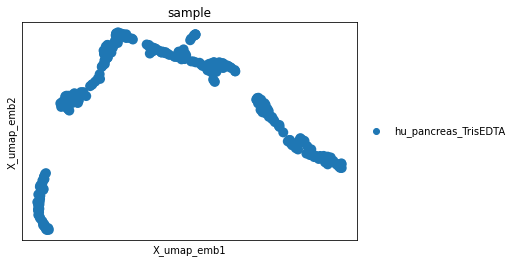

In [20]:
sc.pl.embedding(adata, basis='X_umap_emb', color=['sample'])

In [21]:
adata.obs.index

Index(['hu_pancreas_TrisEDTA_0_0', 'hu_pancreas_TrisEDTA_0_1',
       'hu_pancreas_TrisEDTA_0_13', 'hu_pancreas_TrisEDTA_0_2',
       'hu_pancreas_TrisEDTA_0_20', 'hu_pancreas_TrisEDTA_0_3',
       'hu_pancreas_TrisEDTA_0_4', 'hu_pancreas_TrisEDTA_0_5',
       'hu_pancreas_TrisEDTA_0_6', 'hu_pancreas_TrisEDTA_0_9',
       ...
       'hu_pancreas_TrisEDTA_3_8', 'hu_pancreas_TrisEDTA_4_17',
       'hu_pancreas_TrisEDTA_4_4', 'hu_pancreas_TrisEDTA_5_3',
       'hu_pancreas_TrisEDTA_6_14', 'hu_pancreas_TrisEDTA_6_16',
       'hu_pancreas_TrisEDTA_7_3', 'hu_pancreas_TrisEDTA_8_13',
       'hu_pancreas_TrisEDTA_9_4', 'hu_pancreas_TrisEDTA_9_5'],
      dtype='object', length=300)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

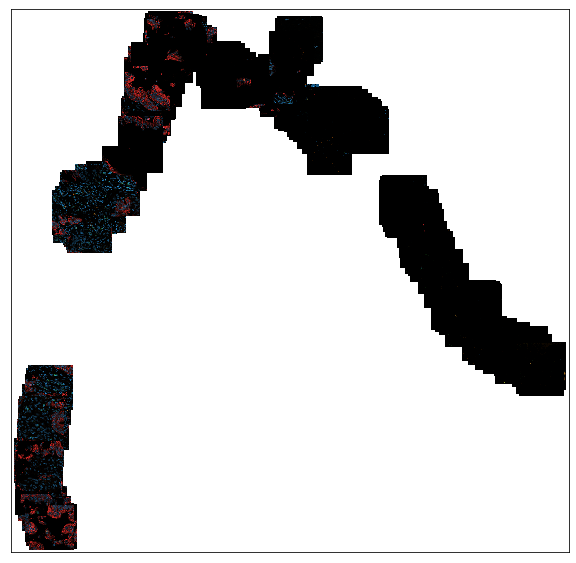

In [22]:
n = 200
idxs = np.random.permutation(adata.obs.index.to_list())[:n]
filtered = adata[idxs]
imgs = [dataloader.dataset[np.where(dataloader.dataset.samples==s)[0][0]] for s in filtered.obs.index]
pseudos = [create_pseudocolor_image(x, dataloader.dataset, ['DAPI', 'CD20', 'CD8', 'pancytok'])
          for x in imgs]
plot_image_umap(
    filtered.obsm['X_umap_emb'][:, 0].flatten(),
    filtered.obsm['X_umap_emb'][:, 1].flatten(),
    pseudos
)

In [23]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [24]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.leiden(adata, resolution=.1)
sc.tl.umap(adata, )

In [25]:
# adata.uns.pop('leiden_colors')

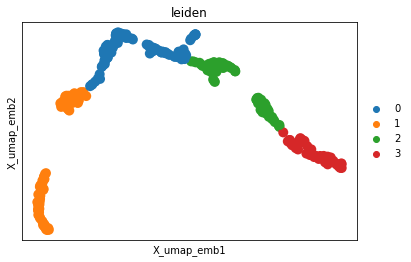

In [26]:
sc.pl.embedding(adata, basis='X_umap_emb', color='leiden')

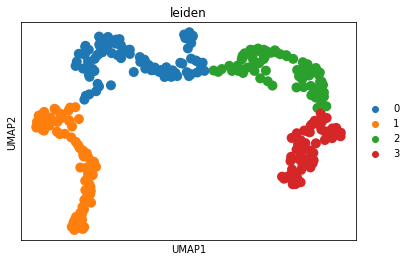

In [27]:
sc.pl.umap(adata, color='leiden')

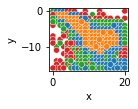

In [28]:
display_2d_scatter(adata.obs, 'leiden', hue_order=sorted(set(adata.obs['leiden'])))
plt.tight_layout()

In [29]:
pseudos = [create_pseudocolor_image(dataloader.dataset[x], dataloader.dataset, ['DAPI', 'CD20', 'CD8', 'pancytok'])
           for x in range(len(dataloader.dataset.samples))]

In [30]:
retiled = retile_multichannel_image(dataloader.dataset.samples, pseudos)
retiled.shape

(3808, 4704, 3)

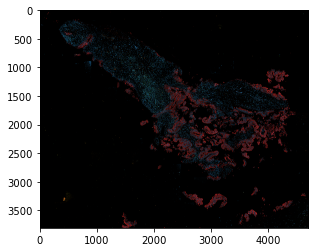

In [31]:
plt.imshow(retiled)

In [ ]:
dapis = [np.sum(dataloader.dataset[x][-7].numpy())
         for x in range(len(dataloader.dataset.samples))]

In [ ]:
adata.obs['dapi'] = dapis
display_2d_scatter(adata.obs, 'dapi', legend=True)

In [ ]:
adata.obs['highlight'] = ['yes' if d>100 else 'no' for d in dapis]
display_2d_scatter(adata.obs, 'highlight', legend=True)

In [ ]:
dataloader.dataset.channels